# Sentiment Analysis in NLP: From Basics to Advanced 😊📊

**Author:** NLP Mastery Series  
**Date:** September 2025

---

## Overview

Sentiment Analysis determines the emotional tone in text and is widely used for social media, customer feedback, and market research. 

This notebook covers from scratch: preprocessing, lexicon methods, classical ML, deep learning, transformers, evaluation, and deployment.

---

## 1. Introduction

*Discussing goals, challenges, sentiment types*

---

## 2. Dataset Loading

In [1]:
from datasets import load_dataset

# Load the IMDB movie reviews dataset
dataset = load_dataset("imdb")

# Overview of splits
print(dataset)                     # -> DatasetDict({'train', 'test', 'unsupervised'})

# Peek at schema/features and a sample row
print(dataset["train"].features)   # e.g., {'text': Value('string'), 'label': ClassLabel(num_classes=2, names=['neg','pos'])}
print(dataset["train"][0])         # {'text': '...', 'label': 0}

# Optional: map numeric labels to names for readability
label_names = dataset["train"].features["label"].names
sample = dataset["train"][0]
print({"text": sample["text"][:120] + " …", "label_id": sample["label"], "label": label_names[sample["label"]]})

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
{'text': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War an


---

## 3. Exploratory Data Analysis

Counts:
 label
0    12500
1    12500
Name: count, dtype: int64

Proportions:
 label
0    0.5
1    0.5
Name: proportion, dtype: float64


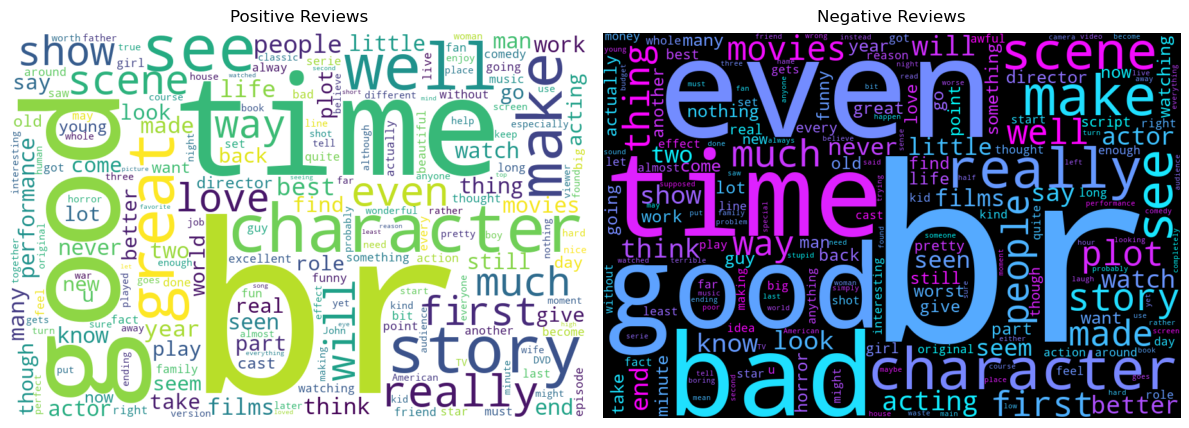

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# 1) Convert HF 'train' split to a proper pandas DataFrame
#    Note: loads into RAM; for big sets consider batching or sampling
train_df = dataset["train"].to_pandas()

# 2) Add review length (vectorized)
train_df["length"] = train_df["text"].str.split().str.len()

# 3) Show class balance (counts and proportions)
print("Counts:\n", train_df["label"].value_counts())
print("\nProportions:\n", train_df["label"].value_counts(normalize=True))

# 4) Build corpora for word clouds
#    Tip: consider sampling for speed/memory, e.g., .sample(n=5000, random_state=42)
pos_text = " ".join(train_df.loc[train_df["label"] == 1, "text"])
neg_text = " ".join(train_df.loc[train_df["label"] == 0, "text"])

# Optional: extend stopwords
extra_stops = {"film", "movie", "one", "like"}
stops = STOPWORDS.union(extra_stops)

# 5) Create and display word clouds
plt.figure(figsize=(12, 5))

wc_pos = WordCloud(
    width=900, height=600,
    background_color="white",
    max_words=200,
    stopwords=stops,
    collocations=False  # avoid joining common bigrams as single tokens
).generate(pos_text)

plt.subplot(1, 2, 1)
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews", pad=8)

wc_neg = WordCloud(
    width=900, height=600,
    background_color="black",
    max_words=200,
    colormap="cool",
    stopwords=stops,
    collocations=False
).generate(neg_text)

plt.subplot(1, 2, 2)
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews", pad=8)

plt.tight_layout()
plt.show()


---

## 4. Text Preprocessing

In [ ]:
import re
import nltk
from typing import Literal
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# One-time downloads (safe to re-run)
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

EN_STOP = set(stopwords.words("english"))
LEMMA = WordNetLemmatizer()

def _to_wordnet_pos(tag: str):
    """Map NLTK POS tags to WordNet POS for improved lemmatization."""
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN  # default fallback

def preprocess_text(
    text: str,
    pos_aware: bool = False  # set True to use POS tags for better lemmas
) -> str:
    """
    Clean -> tokenize -> remove stopwords -> lemmatize -> return string.

    - Lowercases, removes URLs/emails, strips non-letters.
    - Tokenizes with NLTK.
    - Removes English stopwords.
    - Lemmatizes with WordNet; optionally POS-aware for higher accuracy.
    """
    # Normalize and strip URLs/emails
    s = text.lower()
    s = re.sub(r"(?:https?://|www\.)\S+", " ", s)     # URLs
    s = re.sub(r"[\w\.-]+@[\w\.-]+\.\w+", " ", s)     # emails
    s = re.sub(r"[^a-z\s]", " ", s)                   # non-letters -> space
    s = re.sub(r"\s{2,}", " ", s).strip()

    # Tokenization
    tokens = word_tokenize(s)

    # Stopwords removal
    tokens = [w for w in tokens if w not in EN_STOP and len(w) > 1]

    # Lemmatization
    if pos_aware:
        tagged = nltk.pos_tag(tokens)
        tokens = [LEMMA.lemmatize(w, _to_wordnet_pos(pos)) for w, pos in tagged]
    else:
        tokens = [LEMMA.lemmatize(w) for w in tokens]

    return " ".join(tokens)

train_df['clean_text'] = train_df['text'].apply(preprocess_text)

train_df[['text', 'clean_text']].head(3)

[nltk_data] Downloading package punkt to /Users/rahulgarg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rahulgarg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rahulgarg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/rahulgarg/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



---

## 5. Lexicon-Based Sentiment Methods

In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk

# One-time download for VADER lexicon
nltk.download('vader_lexicon')

# Initialize analyzers
sia = SentimentIntensityAnalyzer()

# Ensure text column has strings (avoid NaN issues)
train_df['text'] = train_df['text'].astype(str)

# VADER compound score (-1 to 1)
train_df['vader_score'] = train_df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# TextBlob polarity (-1 to 1)
train_df['textblob_polarity'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
train_df[['text', 'vader_score', 'textblob_polarity']].head(3)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rahulgarg/nltk_data...


,text,vader_score,textblob_polarity
0,I rented I AM CURIOUS-YELLOW from my video sto...,-0.1167,0.139881
1,"""I Am Curious: Yellow"" is a risible and preten...",-0.8648,-0.074702
2,If only to avoid making this type of film in t...,0.8324,0.197727



---

## 6. Classical Machine Learning

_Bag of Words + Naive Bayes Example_

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# 1) Features/labels (fall back to raw text if 'clean_text' absent)
X = train_df['clean_text'] if 'clean_text' in train_df.columns else train_df['text']
y = train_df['label'].astype(int)

# 2) Train/validation split (stratified for balanced class proportions)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Vectorization (TF-IDF with unigrams+bigrams and English stopwords)
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words='english',
    lowercase=True,
    sublinear_tf=True  # dampen high tf values
)

X_train_vec = tfidf.fit_transform(X_train)
X_val_vec   = tfidf.transform(X_val)

# 4) Train Naive Bayes classifier (good baseline for sparse TF-IDF features)
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# 5) Validate
y_pred = model.predict(X_val_vec)

# 6) Metrics
acc = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {acc:.4f}')
print(classification_report(y_val, y_pred, digits=3))

Validation Accuracy: 0.8606
              precision    recall  f1-score   support

           0      0.865     0.854     0.860      2500
           1      0.856     0.867     0.862      2500

    accuracy                          0.861      5000
   macro avg      0.861     0.861     0.861      5000
weighted avg      0.861     0.861     0.861      5000



---

## 7. Transformer-based Sentiment Analysis

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Load pretrained sentiment model from Hugging Face Hub
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

# Device selection (CUDA -> MPS -> CPU)
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device).eval()

# Tokenize example
example_text = "I love this movie! It's fantastic 😍"
inputs = tokenizer(
    example_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=256
)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict sentiment logits and convert to probabilities
with torch.no_grad():
    logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1).squeeze(0).cpu().numpy()

labels = model.config.id2label
pred_id = int(np.argmax(probs))
pred_label = labels[pred_id]

print(f"Probabilities: {probs}")          # e.g., [p(NEG), p(POS)]
print(f"Predicted: {pred_label} ({probs[pred_id]:.4f})")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Probabilities: [1.11953195e-04 9.99888062e-01]
Predicted: POSITIVE (0.9999)


In [9]:
def predict_proba(texts, batch_size=32, max_length=256):
    """
    Returns an (N, C) array of probabilities for N texts and C classes.
    """
    if isinstance(texts, (list, tuple)):
        seqs = list(texts)
    else:
        # Handles pandas Series/Index or any iterable
        seqs = list(texts)

    all_probs = []
    for i in range(0, len(seqs), batch_size):
        batch = seqs[i:i+batch_size]
        enc = tokenizer(
            batch, return_tensors="pt",
            padding=True, truncation=True, max_length=max_length
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
        all_probs.append(probs)
    return np.vstack(all_probs)


train_df['text'] = train_df['text'].astype(str)
P = predict_proba(train_df['text'], batch_size=64)
pred_ids = P.argmax(axis=1)
id2label = model.config.id2label
train_df['hf_label'] = [id2label[int(i)] for i in pred_ids]
train_df['hf_conf']  = P.max(axis=1)
train_df[['text', 'hf_label', 'hf_conf']].head(3)

,text,hf_label,hf_conf
0,I rented I AM CURIOUS-YELLOW from my video sto...,NEGATIVE,0.987419
1,"""I Am Curious: Yellow"" is a risible and preten...",NEGATIVE,0.999243
2,If only to avoid making this type of film in t...,NEGATIVE,0.998218


***

## 8. **Summary and Next Steps**
- Sentiment analysis is a cornerstone NLP task—ranging from simple lexicon methods to advanced transformer fine-tuning.
- Preprocessing greatly impacts model performance—clean data yields better models.
- Classical ML with TF-IDF is fast, interpretable, and effective on many tasks.
- Transformer models provide state-of-the-art results and handle complex language nuances.
- Evaluation and error analysis are crucial for improving and understanding models.
- Next: Explore Aspect-Based Sentiment, Multilingual Sentiment, Explainability, and Deployment.